In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import timeit

In [2]:
df = pd.read_csv("applications data.csv")
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


## Preparation Process

### Deal with original field

In [3]:
# fix data type
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))
df['zip5'] = df['zip5'].apply(lambda x: '{0:0>5}'.format(x))
# fix frivolous values
# ssn
df.loc[df.ssn == 999999999, 'ssn'] = -df[df.ssn==999999999]['record']
df['ssn'] = df['ssn'].apply(lambda x: '{0:0>9}'.format(x))
# address
df.loc[df.address == '123 MAIN ST','address'] = df.loc[df.address == '123 MAIN ST','record'].apply(lambda x: str(x)+'RECORD')
# dob
df.loc[df.dob == 19070626,'dob'] = -df.loc[df.dob==19070626]['record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))
# homephone
df.loc[df.homephone==9999999999,'homephone'] = -df.loc[df.homephone==9999999999]['record']
df['homephone'] = df['homephone'].apply(lambda x:'{0:0>10}'.format(x))

In [4]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


### add day of week and encoding this column

In [6]:
import calendar
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])


In [7]:
train_test = df[df['date']<"2016-11-01"]

In [8]:
# statistical smoothing
c = 4; nmid = 20; y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)
print(y_dow_smooth)

dow
Friday       0.014499
Monday       0.013480
Saturday     0.014968
Sunday       0.013674
Thursday     0.014981
Tuesday      0.014070
Wednesday    0.015169
dtype: float64


In [9]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,dow,dow_risk
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0,Friday,0.014499
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,Friday,0.014499
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,Friday,0.014499
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,Friday,0.014499
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,Friday,0.014499


In [10]:
y_dow = y_dow.reset_index()
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow'] = pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow = y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')

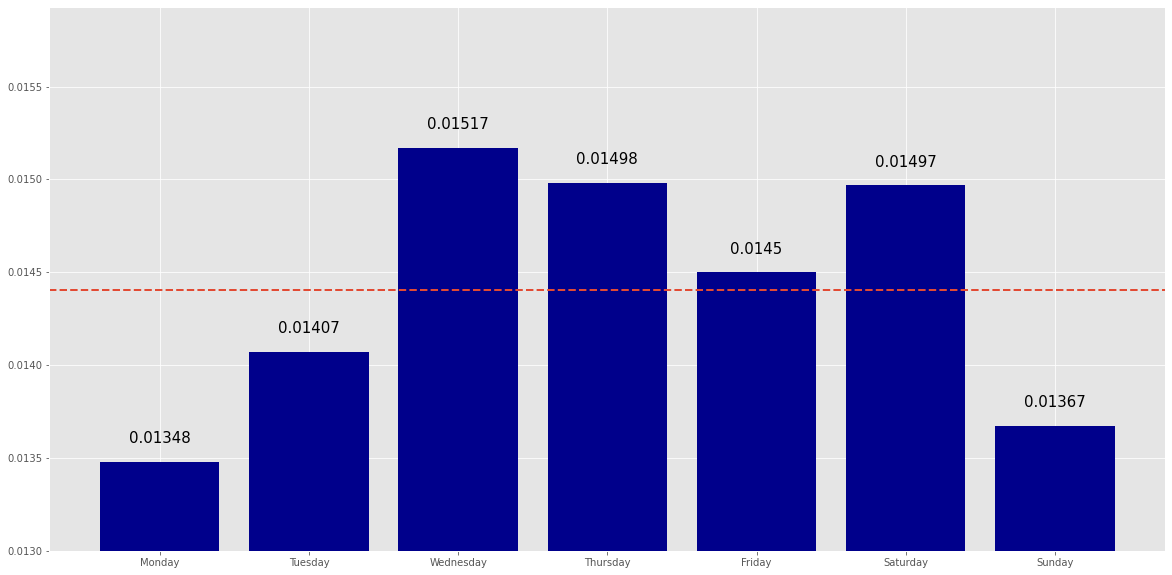

In [11]:
plt.style.use('ggplot')
fig,ax = plt.subplots(figsize = (20,10))
plt.bar(data=y_dow,x=y_dow.index,height="fraud_label",color='darkblue')
ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg,ls='--',lw=2)

for i,v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[i,'fraud_label']+0.0001,round(y_dow.loc[i,'fraud_label'],5),horizontalalignment='center',fontsize=15)
plt.show()

### add age and encoding this column

In [12]:
# calculate age
def calculate_age(birth,application_date):
    birth_d = pd.to_datetime(birth)
    birth_t = birth_d.replace(year=application_date.year)
    if application_date > birth_t:
        age = application_date.year - birth_d.year
    else:
        age = application_date.year - birth_d.year - 1
    return age



In [13]:
# age
age = []
for i,m in zip(df['dob'],df['date']):
    if i[0]=='0':
        age.append(0)
    else:
        age.append(calculate_age(i,m))
df['age'] = age

In [14]:
# age level
age_level = []
for i in age:
    if i ==0:
        age_level.append("MISSING")
    elif i<=4:
        age_level.append("TODDLER")
    elif i<=12:
        age_level.append("CHILD")
    elif i<=19:
        age_level.append("TEEN")
    elif i<=39:
        age_level.append("ADULT")
    elif i<=59:
        age_level.append("MIDDLE AGE ADULT")
    else:
        age_level.append("SENIOR ADULT")
df['age_level'] = age_level

In [15]:
train_test = df[df['date']<"2016-11-01"]

In [16]:
# statistical smoothing
c = 4; nmid = 20; y_avg = train_test['fraud_label'].mean()
y_age = train_test.groupby('age_level')['fraud_label'].mean()
num = train_test.groupby('age_level').size()
y_age_level_smooth = y_avg+(y_age-y_avg)/(1+np.exp(-(num-nmid)/c))
df['age_level_risk'] = df.age_level.map(y_age_level_smooth)
print(y_age_level_smooth)

age_level
ADULT               0.014838
CHILD               0.015472
MIDDLE AGE ADULT    0.015489
MISSING             0.005956
SENIOR ADULT        0.016295
TEEN                0.015681
TODDLER             0.013972
dtype: float64


## make some new vars

### concate basic fields

In [17]:
df['name'] = df.firstname+df.lastname
df['fulladdress'] = df.address+df.zip5
df['name_dob'] = df.name+df.dob
df['name_fulladdress'] = df.name+df.fulladdress
df['name_homephone'] = df.name+df.homephone
df['fulladdress_dob'] = df.fulladdress+df.dob
df['fulladdress_homephone'] = df.fulladdress+df.homephone
df['dob_homephone'] = df.dob+df.homephone
df['homephone_name_dob'] = df.homephone+df.name_dob
df['age_level_address'] = df['age_level']+df['address']
df['age_level_homephone'] = df['age_level'] +df['homephone']

In [18]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'age',
       'age_level', 'age_level_risk', 'name', 'fulladdress', 'name_dob',
       'name_fulladdress', 'name_homephone', 'fulladdress_dob',
       'fulladdress_homephone', 'dob_homephone', 'homephone_name_dob',
       'age_level_address', 'age_level_homephone'],
      dtype='object')

In [19]:
for field in ['firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'age_level','name', 'fulladdress', 'name_dob',
       'age_level_address', 'age_level_homephone']:
    df['ssn_'+field] = df.ssn+df[field]

In [20]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'age',
       'age_level', 'age_level_risk', 'name', 'fulladdress', 'name_dob',
       'name_fulladdress', 'name_homephone', 'fulladdress_dob',
       'fulladdress_homephone', 'dob_homephone', 'homephone_name_dob',
       'age_level_address', 'age_level_homephone', 'ssn_firstname',
       'ssn_lastname', 'ssn_address', 'ssn_zip5', 'ssn_dob', 'ssn_homephone',
       'ssn_age_level', 'ssn_name', 'ssn_fulladdress', 'ssn_name_dob',
       'ssn_age_level_address', 'ssn_age_level_homephone'],
      dtype='object')

In [21]:
attributes = ['ssn','address', 'dob', 'homephone', 'name', 'fulladdress', 'name_dob',
       'name_fulladdress', 'name_homephone', 'fulladdress_dob',
       'fulladdress_homephone', 'dob_homephone', 'homephone_name_dob', 
       'age_level_address', 'age_level_homephone', 'ssn_firstname',
       'ssn_lastname', 'ssn_address', 'ssn_zip5', 'ssn_dob', 'ssn_homephone',
       'ssn_age_level', 'ssn_name', 'ssn_fulladdress', 'ssn_name_dob',
        'ssn_age_level_address','ssn_age_level_homephone']

In [22]:
df1 = df.copy()
vars = df.copy()
df1['check_date']=df1.date
df1['check_record']=df1.record
vars.shape

(1000000, 38)

### velocity/ counts and days since

In [23]:
# total time: 51.94 min
import time
import datetime as dt
begin = time.time()
for entity in attributes:
    st = time.time()
    df_1 = df1[['record','date',entity]]
    df_r = df1[['check_record','check_date',entity]]
    temp = pd.merge(df_1,df_r,left_on=entity,right_on=entity)
    
    #day since
    day_since_df = temp[temp.record>temp.check_record][['record','date','check_date']].groupby('record')[['date','check_date']].last()
    mapper = (day_since_df.date-day_since_df.check_date).dt.days
    vars[entity+'_day_since'] = vars.record.map(mapper)
    vars[entity+'_day_since'].fillna(365,inplace=True)
    print(f'\n{entity}_day_since ---> Done')
    
    #velocity
    for offset_t in [0,1,3,7,14,30]:
        count_day_df = temp[(temp.check_date>=(temp.date - dt.timedelta(offset_t)))&(temp.record>=temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        vars[col_name] = vars.record.map(mapper2)
        
        print(f'{entity}_count_{str(offset_t)} ---> Done')
        
    print(f'Run time for entity {entity} --------- {time.time() -st}s')
print(f"Total run time: {(time.time() - begin)/60}min")


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for entity ssn --------- 5.16326117515564s

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
Run time for entity address --------- 4.05813193321228s

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
Run time for entity dob --------- 25.4774010181427s

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
Run time for entity homephone --------- 20.66239285469055s

name_day_since ---> Done
name_count_0 ---> Done
name_count_1 ---> Done
nam

In [24]:
# relative velocity
# total time: 22.58s
start = time.time()
for att in attributes:
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
            vars[att+'_count_'+d+"_by_"+dd] = vars[att+"_count_"+d]/(vars[att+"_count_"+dd]/float(dd))
print(f'Total run time: {time.time()-start}s')

Total run time: 22.580934047698975s


### remove some cols due to memory limitations

In [25]:
attributes.remove('address')
attributes.remove('dob')
attributes.remove('name')
attributes.remove('ssn_address')
attributes.remove('homephone')
attributes.remove('name_homephone')
attributes.remove("fulladdress_homephone")
attributes.remove("homephone_name_dob")
attributes.remove("ssn_homephone")
attributes.remove("ssn_firstname")
attributes.remove("ssn_dob")

In [26]:
attributes

['ssn',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'fulladdress_dob',
 'dob_homephone',
 'age_level_address',
 'age_level_homephone',
 'ssn_lastname',
 'ssn_zip5',
 'ssn_age_level',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob',
 'ssn_age_level_address',
 'ssn_age_level_homephone']

### number of unique values in the specific field during the past specific period of time

In [27]:
# total time: 87.90 min
begin = time.time()
for entity in attributes:
    for field in attributes:
        st = time.time()
        if field == entity:
            continue
        else:
            df_c = df1[['record','date',entity]]
            df_d = df1[['check_record','check_date',entity,field]]
            temp = pd.merge(df_c,df_d,left_on=entity,right_on=entity)
    
    # num of unique for particular field
        for offset_t in [1,3,7,14,30,60]:
            count_day_df = temp[(temp.check_date>=(temp.date - dt.timedelta(offset_t)))&(temp.record>=temp.check_record)]
            col_name = f'{entity}_unique_count_in_{field}_for_{offset_t}'
            mapper = count_day_df.groupby('record')[entity].nunique()
            vars[col_name] = vars.record.map(mapper)
        
        print(f'Run time for entity {entity} in field {field} --------- {time.time() -st}s')
    print(f"Total run time: {(time.time() - begin)/60}min")

Run time for entity ssn in field fulladdress --------- 18.565182209014893s
Run time for entity ssn in field name_dob --------- 17.57679581642151s
Run time for entity ssn in field name_fulladdress --------- 15.601883172988892s
Run time for entity ssn in field fulladdress_dob --------- 1086.9020071029663s
Run time for entity ssn in field dob_homephone --------- 5.446771144866943s
Run time for entity ssn in field age_level_address --------- 12.026888370513916s
Run time for entity ssn in field age_level_homephone --------- 18.350569009780884s
Run time for entity ssn in field ssn_lastname --------- 18.189234972000122s
Run time for entity ssn in field ssn_zip5 --------- 986.0092887878418s
Run time for entity ssn in field ssn_age_level --------- 32.54234337806702s
Run time for entity ssn in field ssn_name --------- 18.944520950317383s
Run time for entity ssn in field ssn_fulladdress --------- 18.836945295333862s
Run time for entity ssn in field ssn_name_dob --------- 18.94452214241028s
Run ti

Run time for entity age_level_address in field fulladdress_dob --------- 6.473235845565796s
Run time for entity age_level_address in field dob_homephone --------- 6.485093116760254s
Run time for entity age_level_address in field age_level_homephone --------- 6.537596940994263s
Run time for entity age_level_address in field ssn_lastname --------- 6.47160005569458s
Run time for entity age_level_address in field ssn_zip5 --------- 6.45579981803894s
Run time for entity age_level_address in field ssn_age_level --------- 6.542130708694458s
Run time for entity age_level_address in field ssn_name --------- 6.678429841995239s
Run time for entity age_level_address in field ssn_fulladdress --------- 6.623160123825073s
Run time for entity age_level_address in field ssn_name_dob --------- 6.501284837722778s
Run time for entity age_level_address in field ssn_age_level_address --------- 6.775371074676514s
Run time for entity age_level_address in field ssn_age_level_homephone --------- 6.6066629886627

Run time for entity ssn_fulladdress in field age_level_homephone --------- 41.630027770996094s
Run time for entity ssn_fulladdress in field ssn_lastname --------- 6.473246812820435s
Run time for entity ssn_fulladdress in field ssn_zip5 --------- 6.394686937332153s
Run time for entity ssn_fulladdress in field ssn_age_level --------- 6.644680976867676s
Run time for entity ssn_fulladdress in field ssn_name --------- 6.894061088562012s
Run time for entity ssn_fulladdress in field ssn_name_dob --------- 6.945724964141846s
Run time for entity ssn_fulladdress in field ssn_age_level_address --------- 6.694045066833496s
Run time for entity ssn_fulladdress in field ssn_age_level_homephone --------- 6.511685848236084s
Total run time: 80.8573469042778min
Run time for entity ssn_name_dob in field ssn --------- 6.692730903625488s
Run time for entity ssn_name_dob in field fulladdress --------- 6.732704162597656s
Run time for entity ssn_name_dob in field name_dob --------- 6.567763805389404s
Run time 

In [28]:
# total 1883 field
vars.shape

(1000000, 1883)

In [29]:
df1.shape

(1000000, 40)

In [30]:
vars.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label',
       ...
       'ssn_age_level_homephone_unique_count_in_ssn_name_dob_for_7',
       'ssn_age_level_homephone_unique_count_in_ssn_name_dob_for_14',
       'ssn_age_level_homephone_unique_count_in_ssn_name_dob_for_30',
       'ssn_age_level_homephone_unique_count_in_ssn_name_dob_for_60',
       'ssn_age_level_homephone_unique_count_in_ssn_age_level_address_for_1',
       'ssn_age_level_homephone_unique_count_in_ssn_age_level_address_for_3',
       'ssn_age_level_homephone_unique_count_in_ssn_age_level_address_for_7',
       'ssn_age_level_homephone_unique_count_in_ssn_age_level_address_for_14',
       'ssn_age_level_homephone_unique_count_in_ssn_age_level_address_for_30',
       'ssn_age_level_homephone_unique_count_in_ssn_age_level_address_for_60'],
      dtype='object', length=1883)

In [ ]:
vars.to_csv("vars1.csv")